<a href="https://colab.research.google.com/github/yashveersinghsohi/Dive_into_Deep_Learning_Practice/blob/chapter_3/chapter_3/chapter_3_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression Using Sklearn

## Imports

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

## Data

In [4]:
dataset = fetch_california_housing()

In [5]:
X, y = dataset['data'], dataset['target']
features_df = pd.DataFrame(data=X, columns=dataset['feature_names'])
targets_df = pd.DataFrame(data=y, columns=dataset['target_names'])
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

## Getting Model Parameters

In [4]:
lin_reg_sklearn = LinearRegression()
lin_reg_sklearn.fit(X_train, y_train)

LinearRegression()

In [5]:
lin_reg_sklearn.coef_.round(4), lin_reg_sklearn.intercept_.round(4)

(array([ 0.4487,  0.0097, -0.1233,  0.7831, -0.    , -0.0035, -0.4198,
        -0.4337]),
 -37.0233)

## Model Performance

**Train**

In [6]:
mse = mean_squared_error(y_true=y_train, y_pred=lin_reg_sklearn.predict(X_train)).round(4)
rmse = np.sqrt(mse).round(4)
mse, rmse

(0.5179, 0.7197)

**Val**

In [7]:
mse = mean_squared_error(y_true=y_val, y_pred=lin_reg_sklearn.predict(X_val)).round(4)
rmse = np.sqrt(mse).round(4)
mse, rmse

(0.5559, 0.7456)

# Concise Neural Network Style Implementation

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset, Dataset

## Preparing Dataset

In [6]:
dataset = fetch_california_housing()
X, y = dataset['data'], dataset['target']
features_df = pd.DataFrame(data=X, columns=dataset['feature_names'])
targets_df = pd.DataFrame(data=y, columns=dataset['target_names'])
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

In [7]:
class MyDataset(Dataset):
  def __init__(self, data, targets):
    self.data = data
    self.targets = targets

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    X = self.data[idx]
    y = self.targets[idx]
    return X, y

In [8]:
train_dataset = MyDataset(data=X_train, targets=y_train)
val_dataset = MyDataset(data=X_val, targets=y_val)

In [9]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)

## Preparing the Model

In [112]:
class LinearRegressionNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Linear(in_features=8, out_features=1)
    self.net.weight.data.normal_(mean=0, std=0.01)
    self.net.weight.data = self.net.weight.data.to(torch.float64)
    self.net.bias.data.fill_(value=0)
    self.net.bias.data = self.net.bias.data.to(torch.float64)

  def forward(self, X):
    X = X.to(torch.float64)
    return self.net(X).reshape(-1,)

  def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)

In [143]:
lin_reg_nn = LinearRegressionNN()

## Loss Function and Optimizers

In [169]:
loss_fn = nn.MSELoss()
optimizer = SGD

## Training

In [170]:
class Trainer():
  def __init__(
    self, model, optimizer, loss_fn,
    train_dataloader, val_dataloader,
    max_epochs=50, tol=10
  ):
    self.model = model
    self.optimizer = optimizer(params=self.model.parameters(), lr=0.0003)
    # self.optimizer = SGD(params=self.model.parameters(), lr=0.0003)
    self.loss_fn = loss_fn
    self.train_dataloader = train_dataloader
    self.val_dataloader = val_dataloader
    self.max_epochs = max_epochs
    self.train_losses = []
    self.val_losses = []
    self.best_val_loss = float('inf')
    self.best_val_loss_epoch = -1
    self.tol = tol
    self.max_tol = tol

  def fit(self):
    for epoch_idx in range(self.max_epochs):
      if self.tol == 0:
        print('Using Early Stopping')
        break
      self.train_one_epoch()
      self.early_stopping(epoch_idx=epoch_idx)
      print(f'Epoch {epoch_idx}\t Train Loss: {self.train_losses[-1]}\tVal Loss: {self.val_losses[-1]}')
    print(f'Best Model Found at Epoch {self.best_val_loss_epoch}')

  def train_one_epoch(self):
    training_loss = 0
    for features, labels in self.train_dataloader:
      self.optimizer.zero_grad()
      predictions = self.model(features)
      loss = self.loss_fn(predictions, labels)
      training_loss += loss.item()
      loss.backward()
      nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0, norm_type=2)
      self.optimizer.step()
    self.train_losses.append(training_loss/len(self.train_dataloader))

    # model.eval() # REF: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

    val_loss = 0
    with torch.no_grad():
      for features, labels in self.val_dataloader:
        predictions = self.model(features)
        loss = self.loss_fn(predictions, labels)
        val_loss += loss.item()
      self.val_losses.append(val_loss/len(self.val_dataloader))

  def early_stopping(self, epoch_idx):
    current_val_loss = self.val_losses[-1]
    if current_val_loss < self.best_val_loss:
      self.best_val_loss = current_val_loss
      self.best_val_loss_epoch = epoch_idx
      model_path = f'best_model'
      torch.save(self.model.state_dict(), model_path)
      self.tol = self.max_tol
    else:
      self.tol -= 1

In [171]:
trainer = Trainer(
  model=lin_reg_nn, optimizer=optimizer, loss_fn=loss_fn,
  train_dataloader=train_dataloader, val_dataloader=val_dataloader,
  max_epochs=100, tol=1000
)

In [172]:
trainer.fit()

Epoch 0	 Train Loss: 1.1770425325911185	Val Loss: 1.1524611138122132
Epoch 1	 Train Loss: 1.1607955287145848	Val Loss: 1.1863416892185694
Epoch 2	 Train Loss: 1.1508501168747136	Val Loss: 1.1582486815914876
Epoch 3	 Train Loss: 1.168050388521539	Val Loss: 1.0740530120924905
Epoch 4	 Train Loss: 1.1568274712992708	Val Loss: 1.1387437884217508
Epoch 5	 Train Loss: 1.1709692877137812	Val Loss: 1.1177329977929096
Epoch 6	 Train Loss: 1.15567146169512	Val Loss: 1.1230374688882208
Epoch 7	 Train Loss: 1.1452917938398623	Val Loss: 1.2424014996616604
Epoch 8	 Train Loss: 1.162650264016763	Val Loss: 1.194775657321452
Epoch 9	 Train Loss: 1.1645286523846958	Val Loss: 1.1388561173778895
Epoch 10	 Train Loss: 1.1460864990226463	Val Loss: 1.118625094635575
Epoch 11	 Train Loss: 1.1454839380064625	Val Loss: 1.4918924578760329
Epoch 12	 Train Loss: 1.153675434435548	Val Loss: 1.124690574804665
Epoch 13	 Train Loss: 1.1455051888223875	Val Loss: 1.248177014793132
Epoch 14	 Train Loss: 1.141520861601043

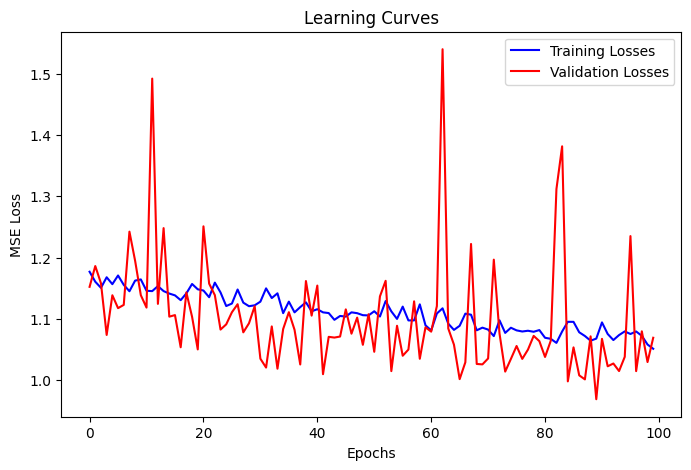

In [173]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(trainer.train_losses, color='blue', label='Training Losses')
ax.plot(trainer.val_losses, color='red', label='Validation Losses')
ax.legend()
ax.set(xlabel='Epochs', ylabel='MSE Loss', title='Learning Curves')
plt.show()

In [174]:
lin_reg_nn_trained = trainer.model

In [175]:
w, b = lin_reg_nn_trained.get_w_b()
w, b

(tensor([[ 0.1182,  0.0129,  0.0287, -0.0029, -0.0002, -0.0037, -0.0286, -0.0173]],
        dtype=torch.float64),
 tensor([0.0001], dtype=torch.float64))